In [2]:
%load_ext autoreload
%autoreload 2

**Imports**

In [3]:
from ultralytics import YOLO
import torch
import cv2
import os
from PIL import Image
import numpy as np
import sys
# from src.CNN_based.inference import load_model
from src.CNN_based.train import SRCNN
import torch.nn as nn
from src.iterative_backprojection import IBP
from src.Self_Similarity.res.python.self_similarity import super_res_self_sim
import matplotlib.pyplot as plt


MODEL_WEIGHTS = "D:\\DIP Project\\srcnn_x3.pth"

In [4]:
img = Image.open("D:\\DIP Project\\Super-resolution-downstream\\test_samples\\meerkat_lr.png").convert("L")
# img = np.array(img).astype(np.float32)

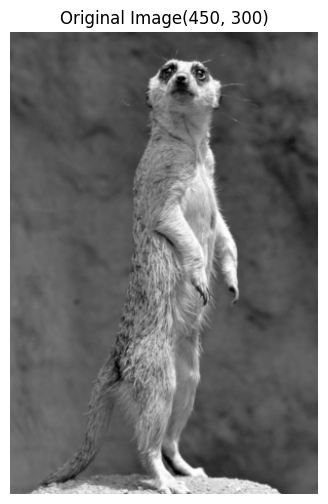

In [5]:
plt.figure(figsize=(6,6))
plt.imshow(np.array(img).astype(np.float32), cmap='gray')
plt.title("Original Image" + f"{np.array(img).astype(np.float32).shape}")
plt.axis('off')
plt.show()

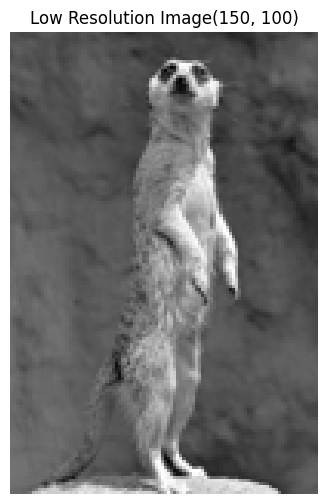

In [6]:
lr_img = img.resize((img.width // 3, img.height // 3), Image.BICUBIC)
plt.figure(figsize=(6,6))
plt.imshow(np.array(lr_img).astype(np.float32), cmap='gray')
plt.title("Low Resolution Image" + f"{np.array(lr_img).shape}")
plt.axis('off')
plt.show()

In [7]:
bicubic_img = lr_img.resize((lr_img.width * 3, lr_img.height * 3), Image.BICUBIC)

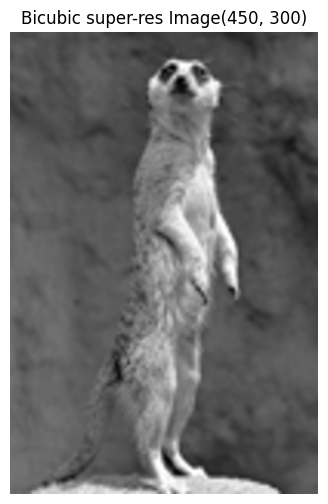

In [8]:
plt.figure(figsize=(6,6))
plt.imshow(np.array(bicubic_img).astype(np.float32), cmap='gray')
plt.title("Bicubic super-res Image" + f"{np.array(bicubic_img).astype(np.float32).shape}")
plt.axis('off')
plt.show()

**Iterative backprojection**

In [9]:
IBP_image = IBP(np.array(lr_img).astype(np.float32), factor_x=3, factor_y=3)
IBP_image.shape

(450, 300)

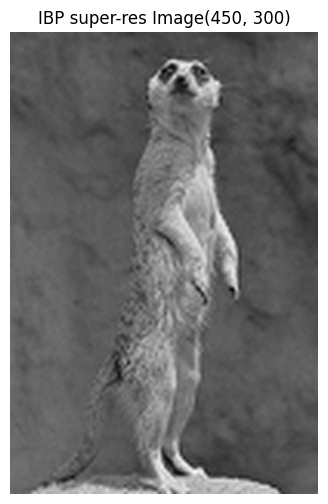

In [10]:
plt.figure(figsize=(6,6))
plt.imshow(np.array(IBP_image).astype(np.float32), cmap='gray')
plt.title("IBP super-res Image" + f"{IBP_image.shape}")
plt.axis('off')
plt.show()

**Local self similarity**

In [11]:
rgb_img = Image.open("D:\\DIP Project\\Super-resolution-downstream\\test_samples\\meerkat_lr.png").convert("RGB")
lr_rgb_img = rgb_img.resize((rgb_img.width // 3, rgb_img.height // 3), Image.BICUBIC)
sr_image = super_res_self_sim(np.array(lr_rgb_img).astype(np.float32)/255.0, s=3)*255.0

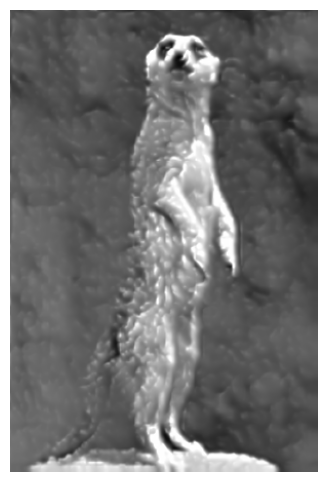

In [12]:
plt.figure(figsize=(6,6))
plt.imshow(np.array(sr_image).astype(np.float32).astype(np.uint8))
plt.axis('off')
plt.show()

The fur on the meerkat in the image produces high frequency components which are exagerrated by the local self similarity method

In [13]:
rgb_img = Image.open("D:\\DIP Project\\Super-resolution-downstream\\test_samples\\cameraman.png").convert("RGB")
lr_rgb_img = rgb_img.resize((rgb_img.width // 3, rgb_img.height // 3), Image.BICUBIC)
sr_image = super_res_self_sim(np.array(lr_rgb_img).astype(np.float32)/255.0, s=3)*255.0

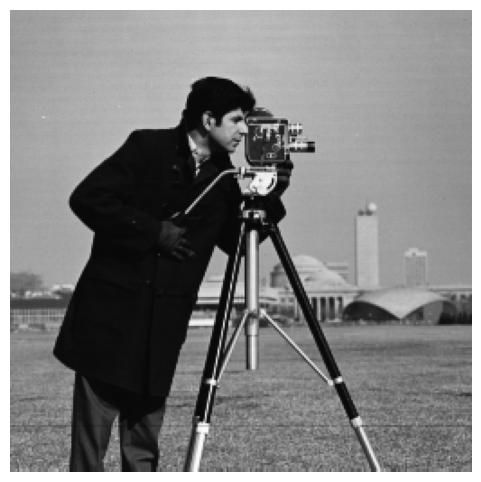

In [25]:
plt.figure(figsize=(6,6))
plt.imshow(np.array(rgb_img).astype(np.float32).astype(np.uint8))
plt.axis('off')
plt.show()

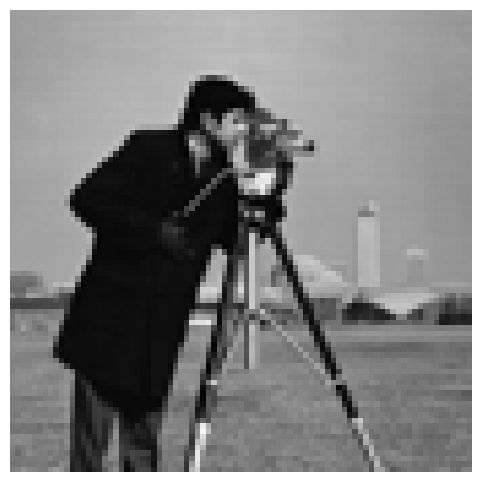

In [23]:
plt.figure(figsize=(6,6))
plt.imshow(np.array(lr_rgb_img).astype(np.float32).astype(np.uint8))
plt.axis('off')
plt.show()

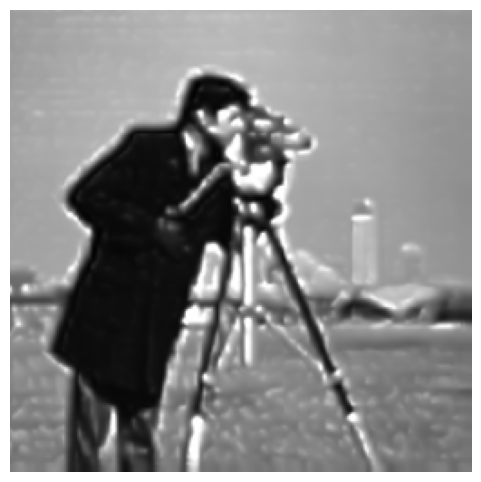

In [14]:
plt.figure(figsize=(6,6))
plt.imshow(np.array(sr_image).astype(np.float32).astype(np.uint8))
plt.axis('off')
plt.show()

This image has high frequency components which the local self similarity method greatly amplifies

In [15]:
from scipy.ndimage import gaussian_filter
def gaussian_blur_3_channel(image, kernel_size=5, sigma=1.0):
    """Applies Gaussian blur to a 3-channel image."""

    blurred_image = np.zeros_like(image)
    for c in range(3):
        blurred_image[:, :, c] = gaussian_filter(image[:, :, c], sigma=sigma, truncate=((kernel_size - 1) / 2) / sigma)
    return blurred_image

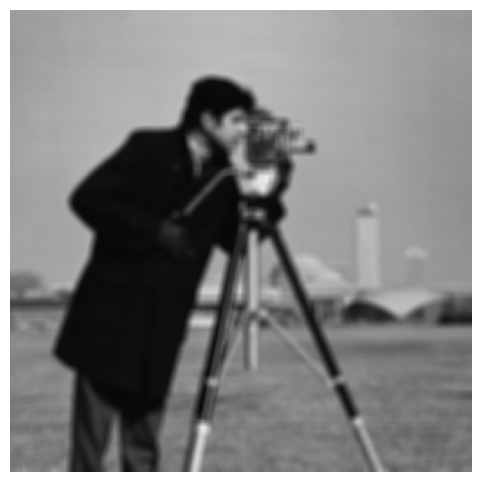

In [28]:
rgb_img = Image.open("D:\\DIP Project\\Super-resolution-downstream\\test_samples\\cameraman.png").convert("RGB")
blurred_img = gaussian_blur_3_channel(np.array(rgb_img).astype(np.float32), kernel_size=5, sigma=3)
# lr_rgb_img = rgb_img.resize((rgb_img.width // 3, rgb_img.height // 3), Image.BICUBIC)
# sr_image = super_res_self_sim(gaussian_blur_3_channel(np.array(lr_rgb_img).astype(np.float32))/255.0, s=3)*255.0

plt.figure(figsize=(6,6))
plt.imshow(np.array(blurred_img).astype(np.float32).astype(np.uint8))
plt.axis('off')
plt.show()

In [29]:
lr_blurred_img = Image.fromarray(blurred_img.astype(np.uint8)).resize((rgb_img.width // 3, rgb_img.height // 3), Image.BICUBIC)
sr_img = super_res_self_sim(np.array(lr_blurred_img).astype(np.float32)/255.0, s=3)*255.0

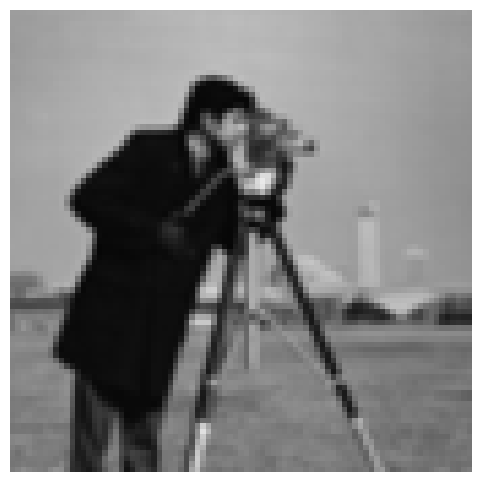

In [30]:
plt.figure(figsize=(6,6))
plt.imshow(np.array(lr_blurred_img).astype(np.float32).astype(np.uint8))
plt.axis('off')
plt.show()

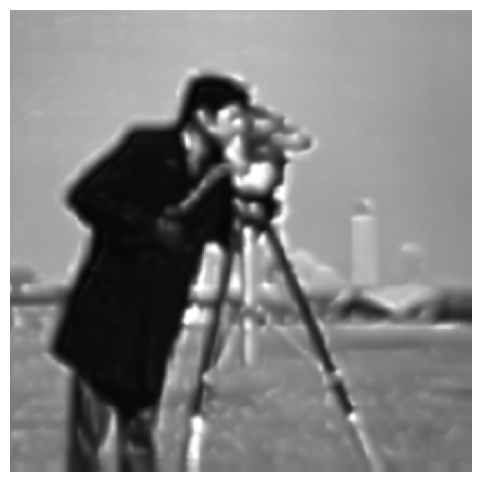

In [31]:
plt.figure(figsize=(6,6))
plt.imshow(np.array(sr_img).astype(np.float32).astype(np.uint8))    
plt.axis('off')
plt.show()

As we can observe, the method of local self similarity greatly amplifies any high frequency components. However, a smooth image gives better reconstruction.

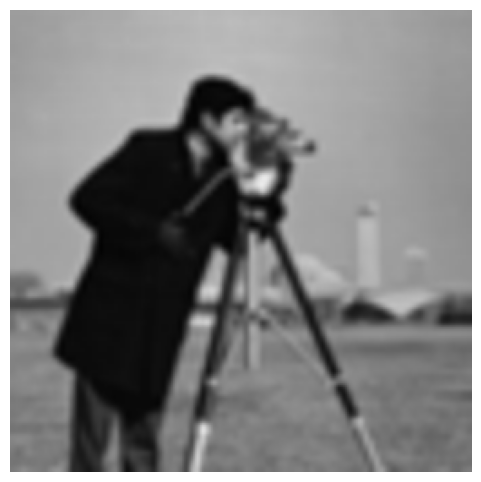

In [32]:
bicubic_lr_blurred = lr_blurred_img.resize((lr_blurred_img.width * 3, lr_blurred_img.height * 3), Image.BICUBIC)

plt.figure(figsize=(6,6))
plt.imshow(np.array(bicubic_lr_blurred).astype(np.float32).astype(np.uint8))
plt.axis('off')
plt.show()

This is a bicubic upsample of the same gaussian blurred image

**SRCNN**

In [29]:
model = SRCNN().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
model.load_state_dict(torch.load(MODEL_WEIGHTS, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))
model.eval()

SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU(inplace=True)
)

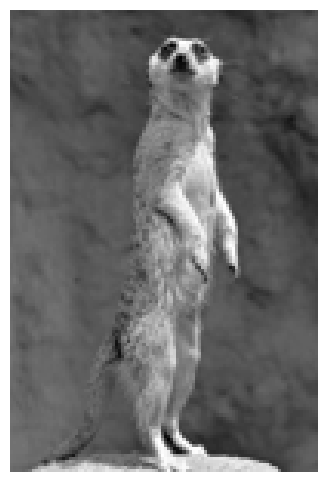

In [ ]:
img = Image.open("D:\\DIP Project\\Super-resolution-downstream\\test_samples\\meerkat_lr.png").convert("L")
lr_img = img.resize((img.width // 3, img.height // 3), Image.BICUBIC)

plt.figure(figsize=(6,6))
plt.imshow(np.array(lr_img).astype(np.float32), cmap='gray')
plt.axis('off')
plt.show()

In [31]:
upsample_guess = lr_img.resize((lr_img.width * 3, lr_img.height * 3), Image.BICUBIC)
input_tensor = torch.from_numpy(np.array(upsample_guess).astype(np.float32)/255.0).unsqueeze(0).unsqueeze(0)
input_tensor = input_tensor.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
with torch.no_grad():
    output_tensor = model(input_tensor)
output_image = output_tensor.squeeze().cpu().numpy() * 255.0
output_image = output_image.clip(0, 255).astype(np.uint8)

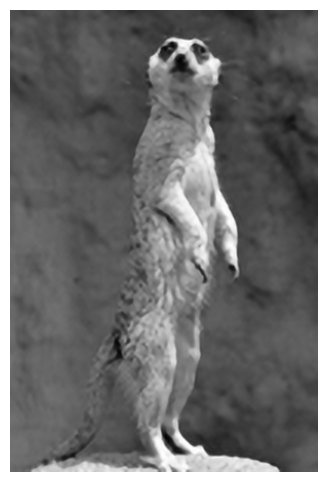

In [32]:
plt.figure(figsize=(6,6))
plt.imshow(output_image, cmap='gray')
plt.axis('off')
plt.show()

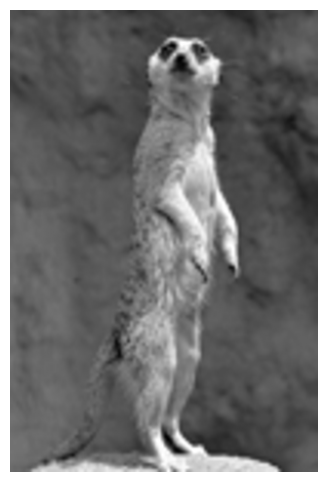

In [33]:
bicubic_upsample = lr_img.resize((lr_img.width * 3, lr_img.height * 3), Image.BICUBIC)
plt.figure(figsize=(6,6))
plt.imshow(np.array(bicubic_upsample).astype(np.float32), cmap='gray')
plt.axis('off')
plt.show()

Bicubic upsample for comparison

**Metrics collected from BSD100, Set5 and Set14 datasets**

In [34]:
f = open("D:\\DIP Project\\Super-resolution-downstream\\quality_assessment\\results.txt", "r")
lines = f.readlines()
for line in lines:
    print(line.strip())
f.close()


Task: Bicubic, Subdir: Set5, Average PSNR: 33.24 dB, Average SSIM: 0.9855
Task: Bicubic, Subdir: Set14, Average PSNR: 32.10 dB, Average SSIM: 0.9653
Task: Bicubic, Subdir: BSD100, Average PSNR: 31.97 dB, Average SSIM: 0.9501
Task: IBP, Subdir: Set5, Average PSNR: 32.69 dB, Average SSIM: 0.9869
Task: IBP, Subdir: Set14, Average PSNR: 31.77 dB, Average SSIM: 0.9689
Task: IBP, Subdir: BSD100, Average PSNR: 31.61 dB, Average SSIM: 0.9546
Task: SRCNN, Subdir: Set5, Average PSNR: 34.01 dB, Average SSIM: 0.9914
Task: SRCNN, Subdir: Set14, Average PSNR: 32.47 dB, Average SSIM: 0.9509
Task: SRCNN, Subdir: BSD100, Average PSNR: 32.29 dB, Average SSIM: 0.9473
Task: self_local, Subdir: Set5, Average PSNR: 30.17 dB, Average SSIM: 0.8510
Task: self_local, Subdir: Set14, Average PSNR: 30.00 dB, Average SSIM: 0.8046
Task: self_local, Subdir: BSD100, Average PSNR: 30.13 dB, Average SSIM: 0.7988


**Yolov8 example inference**

In [37]:
bicubic_upsampled_path = "D:\\DIP Project\\car_testing\\Bicubic\\car_2.jpeg"
SRCNN_upsampled_path = "D:\\DIP Project\\car_testing\\SRCNN\\car_2.jpeg"
# self_local_upsampled_path = "D:\\DIP Project\\car_testing\\self_local\\car_2.jpeg"
IBP_upsampled_path = "D:\\DIP Project\\car_testing\\IBP\\car_2.jpeg"

In [38]:
bicubic_upsample_image = Image.open(bicubic_upsampled_path).convert("RGB")
SRCNN_upsample_image = Image.open(SRCNN_upsampled_path).convert("RGB")
# self_local_upsample_image = Image.open(self_local_upsampled_path).convert("RGB")
IBP_upsample_image = Image.open(IBP_upsampled_path).convert("RGB")



0: 448x640 1 car, 1 truck, 870.2ms
Speed: 24.6ms preprocess, 870.2ms inference, 13.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 car, 13.8ms
Speed: 2.3ms preprocess, 13.8ms inference, 4.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 car, 1 truck, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 3.8ms postprocess per image at shape (1, 3, 448, 640)


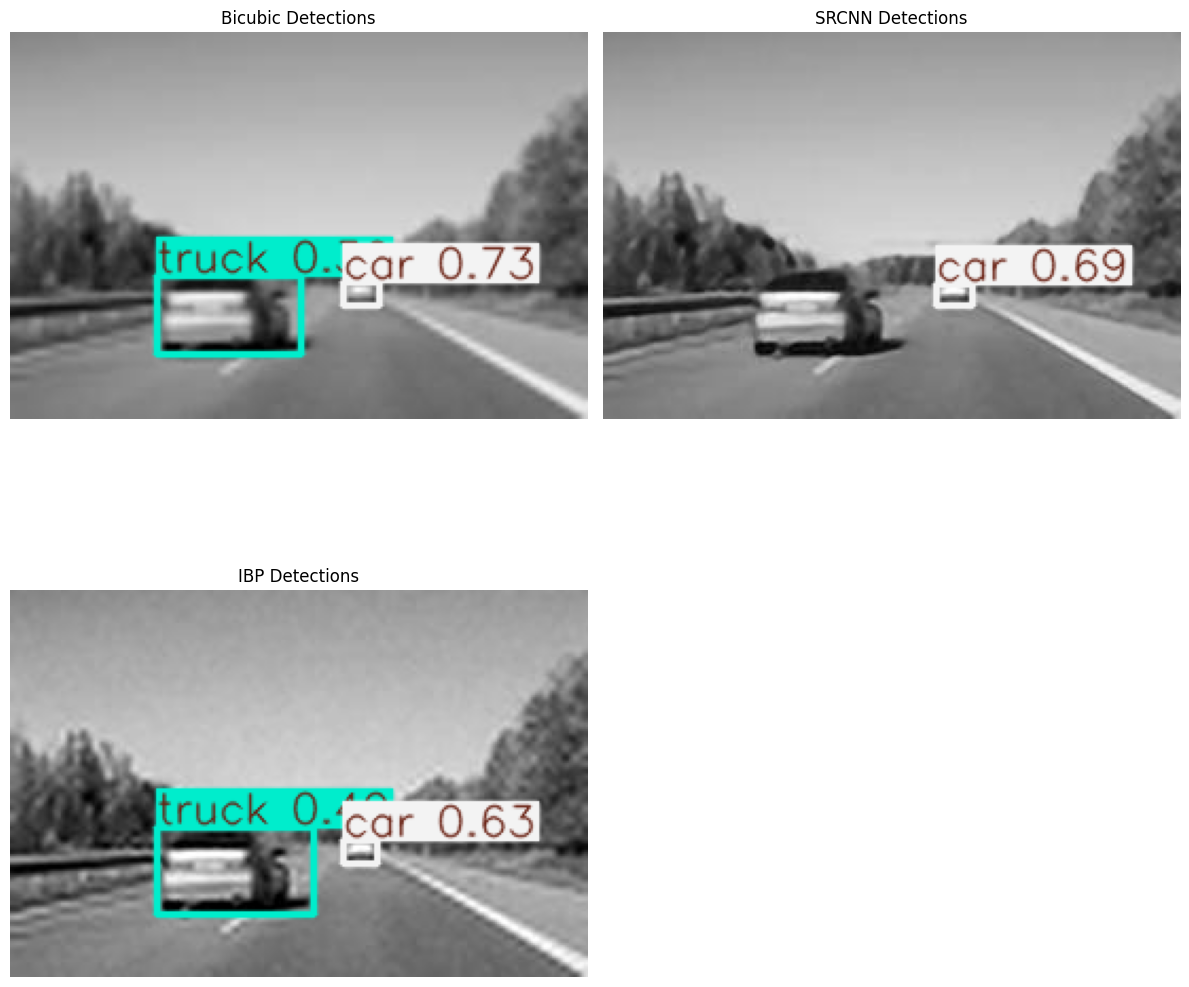

In [39]:
from ultralytics import YOLO
model = YOLO("yolov8n.pt")

def generate_detections(image, model):
    results = model(image)
    result_img = results[0].plot()
    return result_img

bicubic_detections = generate_detections(np.array(bicubic_upsample_image), model)
SRCNN_detections = generate_detections(np.array(SRCNN_upsample_image), model)
# self_local_detections = generate_detections(np.array(self_local_upsample_image), model)
IBP_detections = generate_detections(np.array(IBP_upsample_image), model)

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(bicubic_detections)
plt.title("Bicubic Detections")
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(SRCNN_detections)
plt.title("SRCNN Detections")
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(IBP_detections)
plt.title("IBP Detections")
plt.axis('off')
plt.tight_layout()
plt.show()

Not a lot of difference in confidence measure